# Predicting Seizure Onset in Epileptic Patients Using Intracranial EEG Recordings

## Introduction

Work in progress

An [interesting article](http://cs229.stanford.edu/proj2014/Janet%20An,%20Amy%20Bearman,%20Catherine%20Dong,%20Predicting%20Seizure%20Onset%20in%20Epileptic%20Patients%20Using%20Intercranial%20EEG%20Recordings.pdf) to start working with. It hasn't many details on implementation, but gives some ideas of what to do.

## First steps

Load the data scientist weapons

In [1]:
import scipy.io
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

Load a balanced set of Interictal (Non-Seizure, 0) and Preictal (Pre-Seizure, 1) examples.

In [2]:
import os

from collections import Counter

base_dir_train = u'/train_1/'
base_dir_tests = u'/test_1/'

INTERICTAL = 0
PREICTAL = 1


def get_class_from_name(name):
    """
    Gets the class from the file name.
    
    The class is defined by the last number written in the file name.
    For example:
    
    Input: ".../1_1_1.mat"
    Output: 1.0
    
    Input: ".../1_1_0.mat"
    Output: 0.0
    """
    try:
        return float(name[-5])
    except:
        return 0.0

assert get_class_from_name('/train_1/1_1_0.mat') == 0.0
assert get_class_from_name('/train_1/1_1_1.mat') == 1.0


def get_file_names_and_classes(base_dir, train_samples=600):
    ignored_files = ['.DS_Store', '1_45_1.mat']
    
    return np.array(
        [
            (file, get_class_from_name(file)) 
            for file in os.listdir(base_dir) if file not in ignored_files
        ],
        dtype=[('file', '|S16'), ('class', 'float32')]
    )

data_files_all = get_file_names_and_classes(base_dir_train)

# Count the occurrences of Interictal and Preictal classes
unique, counts = np.unique(data_files_all['class'], return_counts=True)
occurrences = dict(zip(unique, counts))

print('Interictal samples:', occurrences.get(INTERICTAL))
print('Preictal samples:', occurrences.get(PREICTAL))

Interictal samples: 1152
Preictal samples: 149


In [27]:
set_size = 149

# Randomly select an equal-size set of Interictal and Preictal samples
data_random_interictal = np.random.choice(data_files_all[data_files_all['class'] == 0], size=set_size)
data_random_preictal = np.random.choice(data_files_all[data_files_all['class'] == 1], size=set_size)

# Merge the data sets and shufle the collection
data_files = np.concatenate([data_random_interictal, data_random_preictal])
data_files.dtype = data_files_all.dtype  # Sets the same dtype than the original collection
np.random.shuffle(data_files)

print(data_files.shape, data_files.size)

(298,) 298


### Loading data from .mat files

Load data for each file and get the definitive training data.

Then create the `y` based on the classes of the files.
Note that because each file contains 16 channels, it is neccesary to
repeat each class in data_files['class'] 16 times, respecting the order of appearence.

In [28]:
import itertools

from scipy.signal import correlate, resample


def get_X_from_files(base_dir, files, show_progress=True):
    """
    Given a list of filenames, returns the final data we want to train the models.
    """
    X = None

    total_files = len(files)

    for i, filename in enumerate(files):
        if show_progress and i % int(total_files / 10) == 0:
            print(u'%{}: Loading file {}'.format(int(i * 100 / total_files), filename))

        try:
            mat_data = scipy.io.loadmat(''.join([base_dir, filename.decode('UTF-8')]))
        except ValueError as ex:
            print(u'Error loading MAT file {}: {}'.format(filename, str(ex)))
            continue

        # Gets a 16x240000 matrix => 16 channels reading data for 10 minutes at 400Hz
        channels_data = mat_data['dataStruct'][0][0][0].transpose()

        # Resamble each channel to get only a meassurement per second
        # 10 minutes of measurements, grouping data on each second
        channels_data = resample(channels_data, 600, axis=1, window=400)
        
        # It seems that adding bivariate meassurements helps a lot on
        # signals pattern recognition.
        # For each channel, add the correlation meassurements with all the other
        # channels.
        # TODO: This should be done in a more efficient way ¯\_(ツ)_/¯
        correlations = None
        for i in range(16):
            correlations_i = np.array([])
            for j in range (16):
                if i != j:
                    corr_i = correlate(channels_data[i], channels_data[j], mode='same')
                    correlations_i = np.concatenate([correlations_i, corr_i])
                    
            if correlations is None:
                correlations = correlations_i
            else:
                correlations = np.vstack([correlations, correlations_i])

        channels_data = np.column_stack([channels_data, correlations])
        
        X = np.vstack([X, channels_data]) if X is not None else channels_data
    
    return X

In [29]:
X = get_X_from_files(base_dir_train, data_files['file'])
y = np.repeat(data_files['class'], 16, axis=0)

print('X_shape:', X.shape, 'X_size:', X.size)
print('y_shape:', y.shape, 'y_size:', y.size)

%0: Loading file b'1_77_1.mat'
%9: Loading file b'1_66_1.mat'
%19: Loading file b'1_1123_0.mat'
%29: Loading file b'1_158_0.mat'
%38: Loading file b'1_821_0.mat'
%48: Loading file b'1_6_0.mat'
%58: Loading file b'1_11_1.mat'
%68: Loading file b'1_239_0.mat'
%77: Loading file b'1_1142_0.mat'
%87: Loading file b'1_82_1.mat'
%97: Loading file b'1_33_1.mat'
X_shape: (4768, 9600) X_size: 45772800
y_shape: (4768,) y_size: 4768


## Pre-processing

### Resamblation and normalization

Showing case of file: b'1_77_1.mat'


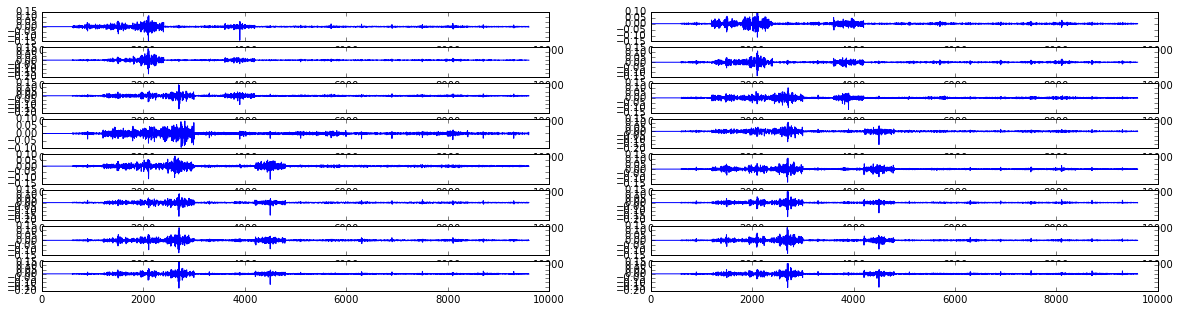

In [30]:
from sklearn.preprocessing import normalize

# Normalizes the data
normalize(X, copy=False)

# Plots a user normalized sample
matplotlib.rcParams['figure.figsize'] = (20.0, 5.0)
print('Showing case of file:', data_files['file'][0])
for i in range(16):
    plt.subplot(8, 2, i + 1)
    plt.plot(X[i])

# Model selection and predictions

In [31]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [39]:
from sklearn import linear_model

clf = linear_model.LogisticRegression(C=16, n_jobs=1, solver='liblinear', verbose=5)

In [40]:
%time clf.fit(X_train, y_train)
clf.score(X_test, y_test)

[LibLinear]CPU times: user 13.5 s, sys: 0 ns, total: 13.5 s
Wall time: 13.5 s


0.69567979669631508

In [41]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

%time y_pred = clf.predict(X_test)

print(u'Accuracy:', accuracy_score(y_test, y_pred))
print(u'Precision:', precision_score(y_test, y_pred))
print(u'Recall:', recall_score(y_test, y_pred))
print(u'F1 score:', f1_score(y_test, y_pred, average='binary'))

CPU times: user 40 ms, sys: 0 ns, total: 40 ms
Wall time: 21 ms
Accuracy: 0.695679796696
Precision: 0.684848484848
Recall: 0.720663265306
F1 score: 0.702299564947


# Results

60 samples (50/50)
-------------------

(C=.1, n_jobs=1, solver='liblinear')
```
CPU times: user 0 ns, sys: 10 ms, total: 10 ms
Wall time: 5.49 ms
Accuracy: 0.637223974763
Precision: 0.627218934911
Recall: 0.670886075949
F1 score: 0.648318042813
```

120 samples (50/50)
-------------------

(C=.1, n_jobs=1, solver='liblinear')

```
CPU times: user 10 ms, sys: 0 ns, total: 10 ms
Wall time: 6.98 ms
Accuracy: 0.61356466877
Precision: 0.611111111111
Recall: 0.597444089457
F1 score: 0.604200323102
```

(C=1, n_jobs=1, solver='liblinear')

```
CPU times: user 0 ns, sys: 20 ms, total: 20 ms
Wall time: 10.9 ms
Accuracy: 0.652996845426
Precision: 0.650485436893
Recall: 0.642172523962
F1 score: 0.646302250804
```

(C=10, n_jobs=1, solver='liblinear')

```
CPU times: user 10 ms, sys: 0 ns, total: 10 ms
Wall time: 7.13 ms
Accuracy: 0.708201892744
Precision: 0.703821656051
Recall: 0.70607028754
F1 score: 0.704944178628
```

238 samples
-----------

(C=16, n_jobs=1, solver='liblinear')

```
CPU times: user 40 ms, sys: 0 ns, total: 40 ms
Wall time: 21 ms
Accuracy: 0.695679796696
Precision: 0.684848484848
Recall: 0.720663265306
F1 score: 0.702299564947
```